# Formula One Project: Modeling

DUE: December 4th, 2024 (Wed)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description

Copy over the important cells from the previous step that read in and cleaned your data to this new notebook file. You do not need to copy over all your EDA and plots describing your data, only the code that prepares your data for modeling. This notebook is about exploring the development of predictive models. Some initial preliminary work on applying some modeling techniques should be completed.
Be sure to commit and push all supporting code that you've completed in this file. Include in this notebook a summary cell at the top that details your accomplishments, challenges, and what you expect to accomplish for your final steps. Be sure to update your readme.md in your repository.

In [14]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import fastf1
import fastf1.plotting
from fastf1.ergast.structure import FastestLap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [4]:
# FastF1 general setup
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)

In [5]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'British Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'São Paulo Grand Prix'] 

In [8]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                print(f"Processing {year} {event_name} - {session_name}")
                
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    
if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)

Processing 2021 Bahrain Grand Prix - Race


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
c

Processing 2021 British Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '4', '3', '14', '5', '31', '55', '10', '63', '7', '18', '99', '22', '6', '47', '9', '11']
core       

Processing 2021 United States Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '55', '3', '4', '10', 

Processing 2021 Mexico City Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '11', '10', '55', '3', '16', '5', '7', '99', '14', '6', '47', '9', '63', '22', '4', '31', '18']
core       

Processing 2021 São Paulo Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '55', '11', '4', '16', '10', '31', '5', '44', '3', '14', '99', '18', '22', '6', '63', '47', '9', '7']
core       

Processing 2022 Bahrain Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']
core     

Processing 2022 British Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '11', '44', '4', '14', '63', '24', '6', '10', '77', '22', '3', '31', '23', '20', '5', '47', '18']
events    

Processing 2022 United States Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '44', '63', '18', '4', '77', '23', '11', '5', '10', '16', '20', '14', '3', '47', '6', '24', '22', '31']
core      

Processing 2022 Mexico City Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '44', '11', '55', '77', '16', '4', '14', '31', '3', '24', '22', '10', '47', '5', '23', '6', '20', '18']
core      

Processing 2022 São Paulo Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '1', '11', '16', '4', '55', '20', '5', '10', '3', '47', '24', '77', '18', '31', '14', '6', '23', '22']
core      

Processing 2023 Bahrain Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core    

Processing 2023 British Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '11', '22', '24', '21', '20', '77']
events  

Processing 2023 United States Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '4', '44', '55', '63', '1', '10', '31', '11', '81', '22', '24', '77', '3', '23', '2', '20', '27', '14', '18']
core     

Processing 2023 Mexico City Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '3', '11', '44', '81', '63', '77', '24', '10', '27', '14', '23', '31', '20', '4', '22', '2', '18']
core     

Processing 2023 São Paulo Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '18', '14', '44', '4', '55', '63', '11', '81', '27', '20', '23', '31', '10', '22', '3', '77', '2', '24']
core     

Processing 2024 Bahrain Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']
core     

Processing 2024 British Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '4', '1', '81', '27', '55', '18', '23', '14', '16', '2', '22', '24', '3', '77', '20', '31', '10', '11']
events   

Processing 2024 United States Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '55', '16', '81', '10', '14', '20', '11', '22', '27', '31', '18', '23', '43', '77', '44', '24', '30', '63']
core   

Processing 2024 Mexico City Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '4', '16', '63', '44', '20', '10', '23', '27', '22', '30', '14', '18', '77', '43', '81', '11', '24', '31']
core   

Processing 2024 São Paulo Grand Prix - Race


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loadin

In [21]:
# Feature Engineering (per event)
def engineer_features(df):
    """
    Create F1-specific features that affect lap times:
    - Tire age effect (exponential decay)
    - Track evolution (improving grip over session)
    - Weather impact (combined temperature effects)
    """
    # Tire performance degradation (exponential)
    df['TyreAgeFactor'] = np.exp(-0.02 * df['TyreLife'])
    
    # Track evolution (grip improvement)
    df['TrackEvolution'] = df.groupby(['Event', 'Year'])['LapNumber'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    
    # Combined temperature effect (track and air)
    df['TempDelta'] = df['TrackTemp'] - df['AirTemp']
    
    # Fuel load effect (decreasing over race)
    df['FuelEffect'] = 1 - (df['LapNumber'] / df.groupby(['Event', 'Year'])['LapNumber'].transform('max'))
    
    return df

In [22]:
# Prepare data for modeling (per event)
def prepare_modeling_data(df):
    # Engineer features
    data = engineer_features(df)
    
    # Select features for modeling
    feature_columns = [
        'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed',
        'TyreLife', 'TyreAgeFactor', 'TrackEvolution',
        'TempDelta', 'FuelEffect', 'SpeedI1', 'SpeedI2'
    ]
    
    # Create dummy variables for categorical features (excluding Event)
    data = pd.get_dummies(data, columns=['Compound', 'Team'])
    
    # Add categorical columns to features
    feature_columns.extend([col for col in data.columns if col.startswith(('Compound_', 'Team_'))])
    
    return data, feature_columns

In [23]:
# Split and scale data
def prepare_train_test(data, feature_columns, target_column='LapTime_seconds'):
    X = data[feature_columns]
    y = data[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [24]:
# Model training and evaluation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        results[name] = {
            'RMSE': rmse,
            'R2': r2,
            'CV_R2_mean': cv_scores.mean(),
            'CV_R2_std': cv_scores.std()
        }
        
    return results, models

In [25]:
# Train models for each event
def train_event_models(merged_data):
    event_models = {}
    event_results = {}
    
    for event in merged_data['Event'].unique():
        print(f"\nTraining models for {event}")
        
        # Filter data for this event
        event_data = merged_data[merged_data['Event'] == event].copy()
        
        # Prepare data
        data, feature_columns = prepare_modeling_data(event_data)
        X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_train_test(
            data, feature_columns
        )
        
        # Train and evaluate models
        results, models = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)
        
        # Store results
        event_models[event] = models
        event_results[event] = results
        
        # Print results for this event
        print(f"\nModel Performance for {event}:")
        for name, metrics in results.items():
            print(f"\n{name}:")
            print(f"RMSE: {metrics['RMSE']:.2f} seconds")
            print(f"R2 Score: {metrics['R2']:.3f}")
            print(f"Cross-validation R2: {metrics['CV_R2_mean']:.3f} (±{metrics['CV_R2_std']:.3f})")
        
        # Feature importance for best model
        best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
        if best_model_name in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
            best_model = models[best_model_name]
            feature_importance = pd.DataFrame({
                'feature': feature_columns,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
            plt.title(f'Top 15 Most Important Features for {event} ({best_model_name})')
            plt.tight_layout()
            plt.show()
    
    return event_models, event_results


Training models for Bahrain Grand Prix

Model Performance for Bahrain Grand Prix:

Linear Regression:
RMSE: 5.63 seconds
R2 Score: 0.490
Cross-validation R2: 0.621 (±0.031)

Random Forest:
RMSE: 2.71 seconds
R2 Score: 0.882
Cross-validation R2: 0.886 (±0.023)

XGBoost:
RMSE: 2.99 seconds
R2 Score: 0.857
Cross-validation R2: 0.868 (±0.023)

Gradient Boosting:
RMSE: 2.91 seconds
R2 Score: 0.864
Cross-validation R2: 0.876 (±0.021)


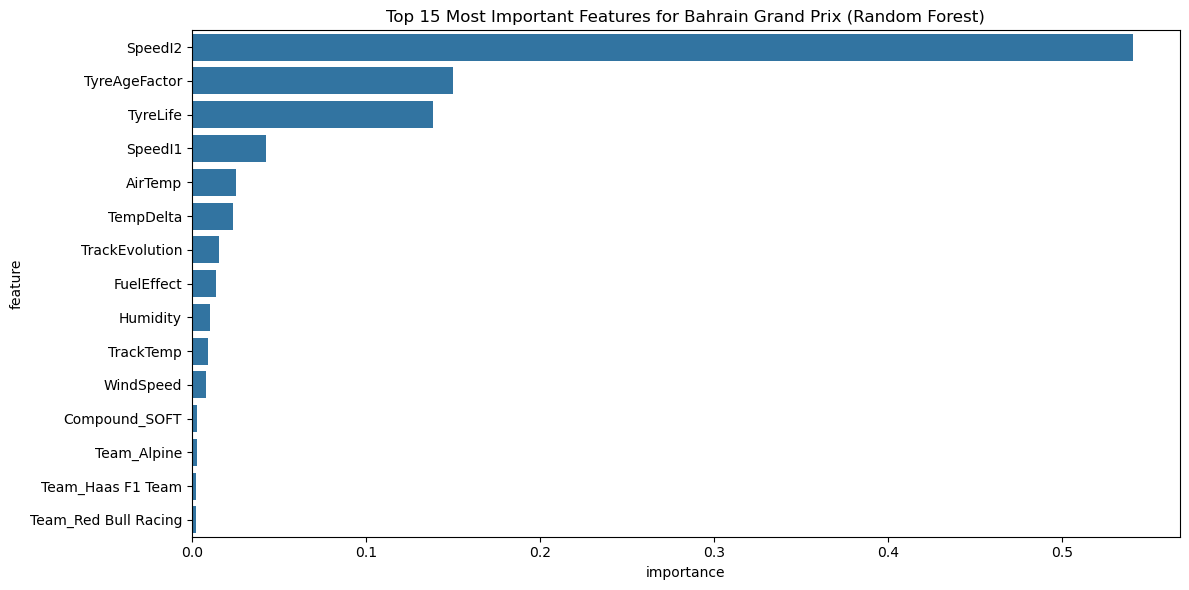


Training models for Mexico City Grand Prix

Model Performance for Mexico City Grand Prix:

Linear Regression:
RMSE: 5.77 seconds
R2 Score: 0.681
Cross-validation R2: 0.686 (±0.028)

Random Forest:
RMSE: 1.96 seconds
R2 Score: 0.963
Cross-validation R2: 0.945 (±0.010)

XGBoost:
RMSE: 2.39 seconds
R2 Score: 0.945
Cross-validation R2: 0.941 (±0.008)

Gradient Boosting:
RMSE: 2.26 seconds
R2 Score: 0.951
Cross-validation R2: 0.939 (±0.014)


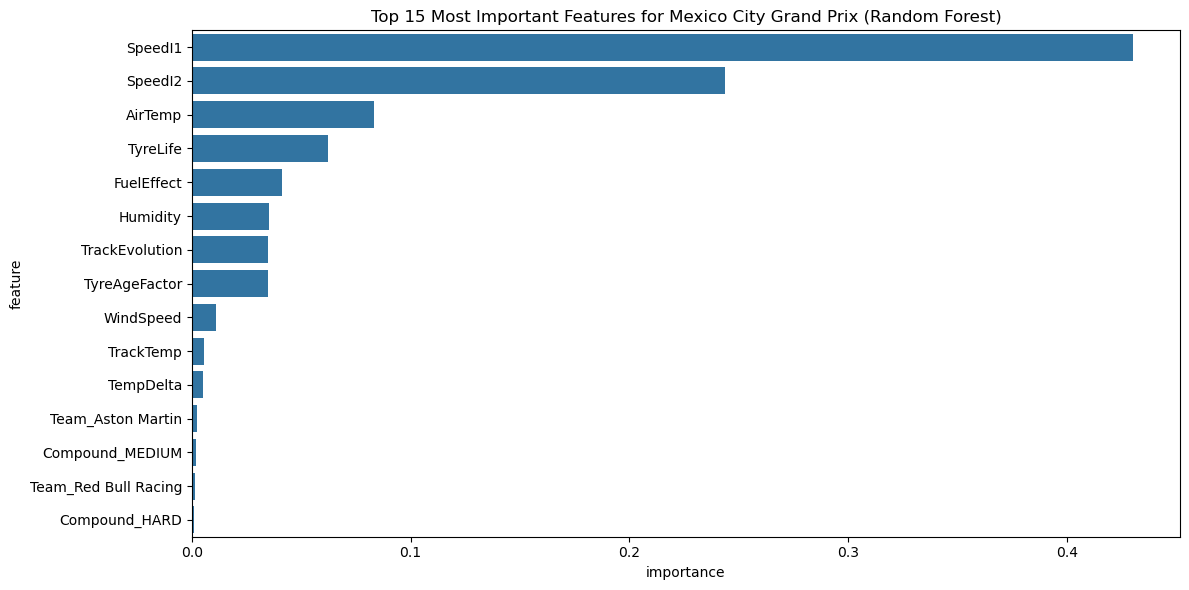


Training models for United States Grand Prix

Model Performance for United States Grand Prix:

Linear Regression:
RMSE: 4.67 seconds
R2 Score: 0.520
Cross-validation R2: 0.496 (±0.059)

Random Forest:
RMSE: 2.49 seconds
R2 Score: 0.863
Cross-validation R2: 0.852 (±0.022)

XGBoost:
RMSE: 2.45 seconds
R2 Score: 0.868
Cross-validation R2: 0.852 (±0.015)

Gradient Boosting:
RMSE: 2.71 seconds
R2 Score: 0.838
Cross-validation R2: 0.860 (±0.020)


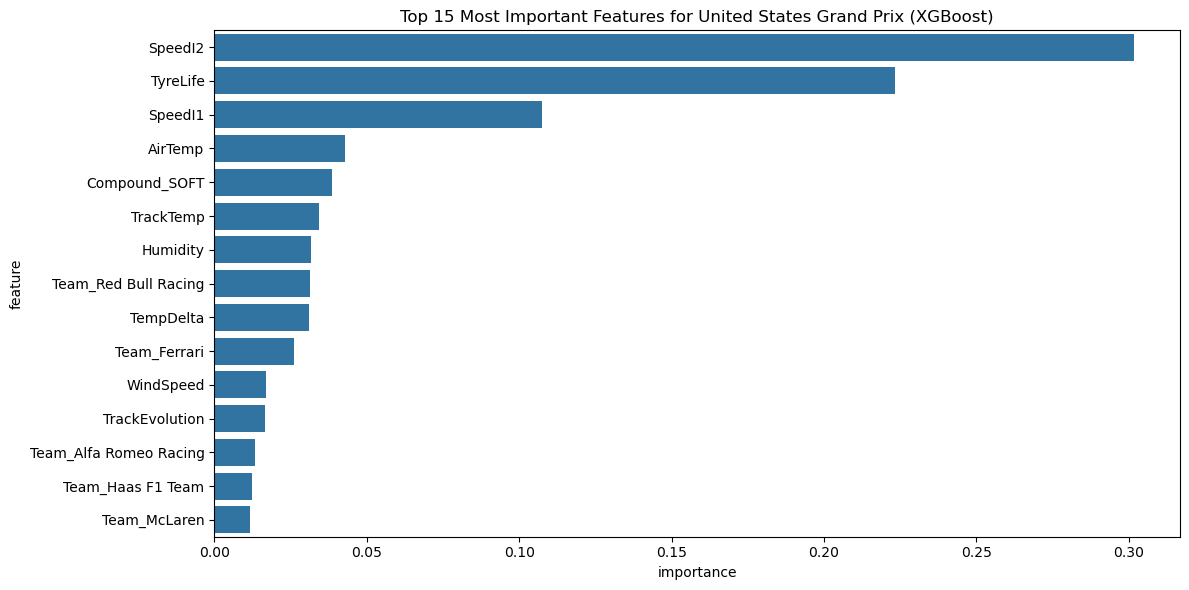


Training models for British Grand Prix

Model Performance for British Grand Prix:

Linear Regression:
RMSE: 6.47 seconds
R2 Score: 0.680
Cross-validation R2: 0.717 (±0.030)

Random Forest:
RMSE: 3.66 seconds
R2 Score: 0.898
Cross-validation R2: 0.939 (±0.020)

XGBoost:
RMSE: 3.64 seconds
R2 Score: 0.899
Cross-validation R2: 0.933 (±0.022)

Gradient Boosting:
RMSE: 3.66 seconds
R2 Score: 0.898
Cross-validation R2: 0.925 (±0.020)


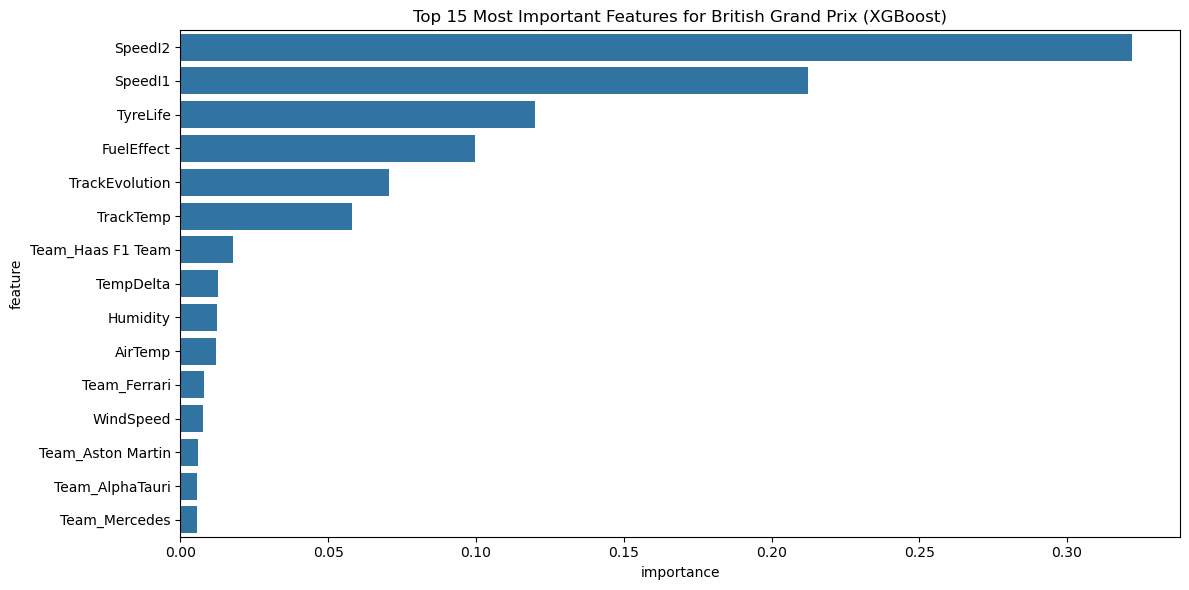


Training models for São Paulo Grand Prix

Model Performance for São Paulo Grand Prix:

Linear Regression:
RMSE: 4.66 seconds
R2 Score: 0.837
Cross-validation R2: 0.843 (±0.026)

Random Forest:
RMSE: 1.91 seconds
R2 Score: 0.973
Cross-validation R2: 0.956 (±0.010)

XGBoost:
RMSE: 2.01 seconds
R2 Score: 0.970
Cross-validation R2: 0.957 (±0.010)

Gradient Boosting:
RMSE: 2.35 seconds
R2 Score: 0.959
Cross-validation R2: 0.951 (±0.011)


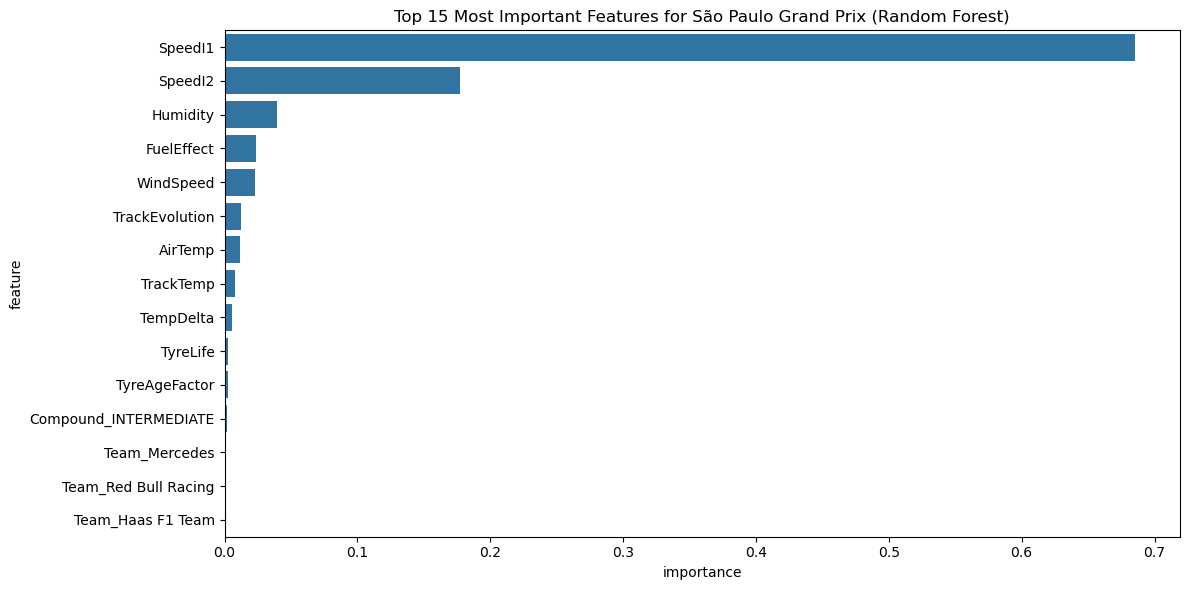

In [26]:
# Execute the modeling pipeline
event_models, event_results = train_event_models(merged_data)

<Figure size 1200x600 with 0 Axes>

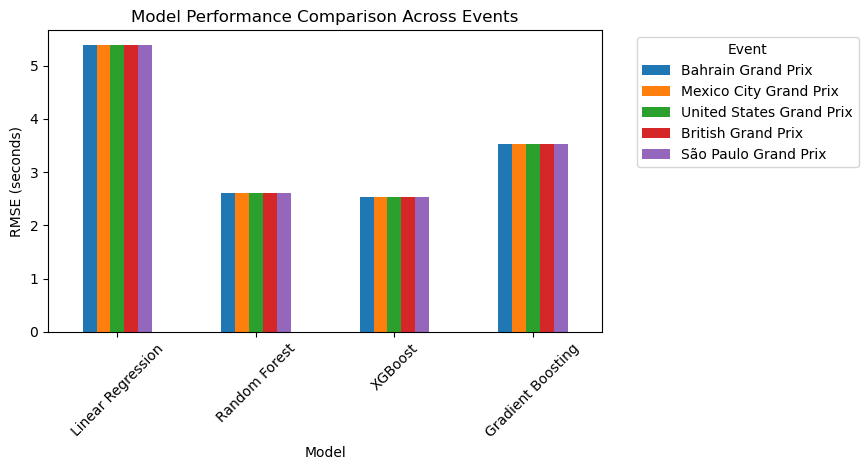

In [27]:
# Compare performance across events
comparison_df = pd.DataFrame({
    event: {model: results[model]['RMSE'] 
           for model in event_results[event].keys()}
    for event in event_results.keys()
})

# Visualize performance comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar')
plt.title('Model Performance Comparison Across Events')
plt.xlabel('Model')
plt.ylabel('RMSE (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Event', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()